In [1]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy import asarray
np.set_printoptions(precision=5)#show 5 number after decimal point 

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
base_dir = r"data"  # Define your base directory
label = []       # Labels for each category
images_path = [] # Paths of all images
all_images = []  # Names of all images
img_label = []   # Labels corresponding to each image

for directory in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, directory)):
        label.append(directory)
        # Using glob to find all jpg, jpeg, and png files
        for img_path in glob.glob(os.path.join(base_dir, directory, '*.jpg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.jpeg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.png')):
            img_name = os.path.basename(img_path)
            all_images.append(img_name)
            images_path.append(img_path)
            img_label.append(directory)

In [3]:
def upload_data(vehicle_dir, non_vehicle_dir):
    data_in_matrix = []
    
    for img_name in tqdm(os.listdir(vehicle_dir)):
        img_path = os.path.join(vehicle_dir, img_name)
        image = Image.open(img_path)  
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 1]) 

    # Upload non-vehicle images
    for img_name in tqdm(os.listdir(non_vehicle_dir)):
        img_path = os.path.join(non_vehicle_dir, img_name)
        image = Image.open(img_path) 
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 0])  

    # Convert data to a NumPy array
    data_in_matrix = np.array(data_in_matrix, dtype=object)
    
    return data_in_matrix

# Define the paths
vehicles_url = r"data\vehicles"
non_vehicles_url = r"data\non-vehicles"

In [5]:
# Load the data_in_matrix variable
data_in_matrix = np.load('data_in_matrix.npy', allow_pickle=True)

In [6]:
def extract_features_labels(data):
    X = []
    y = []

    for image_array, label in data:
        X.append(image_array)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [7]:
# Extract features (X) and labels (y)
mat_x, mat_y = extract_features_labels(data_in_matrix)

In [8]:
mat_x = mat_x/255.0

In [9]:
#split the data to train and test 
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(mat_x,mat_y, test_size=0.2, random_state=42)
#split the train
X_train_mat, X_val_mat, y_train_mat, y_val_mat = train_test_split(X_train_mat,y_train_mat, test_size=0.2, random_state=42)

In [10]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : { label}")
print(f"Total Images : {len(all_images)}")
print(f" Images shape : {img_shape.shape}")

Labels : ['non-vehicles', 'vehicles']
Total Images : 17760
 Images shape : (64, 64, 3)


In [13]:
data =pd.DataFrame({'image':images_path,'label':img_label}) 
data.head()

,image,label
0,data\non-vehicles\extra1.png,non-vehicles
1,data\non-vehicles\extra10.png,non-vehicles
2,data\non-vehicles\extra100.png,non-vehicles
3,data\non-vehicles\extra1000.png,non-vehicles
4,data\non-vehicles\extra1001.png,non-vehicles


In [14]:
data = data.sample(frac=1).reset_index()
data.head()

,index,image,label
0,16738,data\vehicles\middle (154).png,vehicles
1,5210,data\non-vehicles\image1126.png,non-vehicles
2,10477,data\vehicles\236.png,vehicles
3,11022,data\vehicles\2850.png,vehicles
4,13817,data\vehicles\5366.png,vehicles


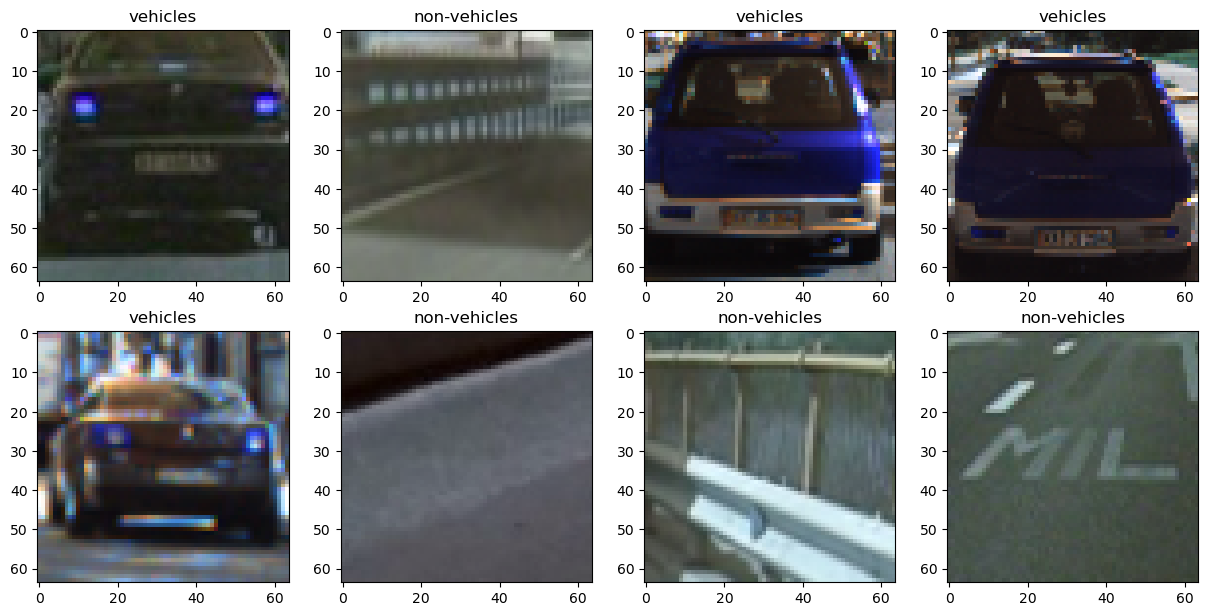

In [15]:
fig = plt.figure(figsize=(15,15))

for i in range(8):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)
    
plt.show()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17760 non-null  int64 
 1   image   17760 non-null  object
 2   label   17760 non-null  object
dtypes: int64(1), object(2)
memory usage: 416.4+ KB


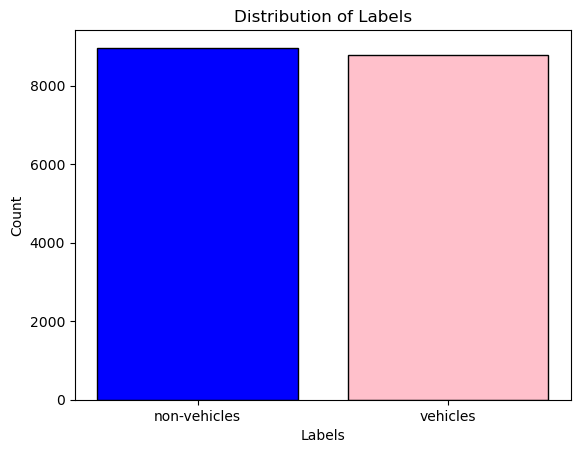

In [18]:
value_counts = data['label'].value_counts()

# Plotting
plt.bar(value_counts.index, value_counts.values, color=['blue', 'pink'],linewidth=1, edgecolor="black")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


### As we can see the data is more or less equally distributed.

In [19]:
X = data.drop(['index','label'],axis=1)
Y = data.label

In [21]:
X.head()

,image
0,data\vehicles\middle (154).png
1,data\non-vehicles\image1126.png
2,data\vehicles\236.png
3,data\vehicles\2850.png
4,data\vehicles\5366.png


In [22]:
X_train, X_final_test, y_train, y_final_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_final_test.shape)

(14208, 1)
(3552, 1)


In [23]:
y_train

15610    non-vehicles
5230     non-vehicles
15224        vehicles
83           vehicles
14570        vehicles
             ...     
11284    non-vehicles
11964        vehicles
5390         vehicles
860      non-vehicles
15795    non-vehicles
Name: label, Length: 14208, dtype: object

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [25]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_mat, y_train_mat)
y_pred = dummy_clf.predict(X_val_mat)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val_mat),3))

The DummyClassifier score is: 0.497


In [26]:
# Define logistic regression model using TensorFlow 2.x
class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(64, 64))  # Flatten input images
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the logistic regression model
model = LogisticRegression()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val_mat, y_val_mat)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(X_val_mat)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_val_mat, y_pred)
print("Accuracy Score:", accuracy)



Epoch 1/50


356/356 [==============================] - 9s 9ms/step - loss: 0.4069 - accuracy: 0.8298 - val_loss: 0.2936 - val_accuracy: 0.8962
Epoch 2/50
356/356 [==============================] - 2s 5ms/step - loss: 0.3078 - accuracy: 0.8791 - val_loss: 0.2797 - val_accuracy: 0.8937
Epoch 3/50
356/356 [==============================] - 2s 5ms/step - loss: 0.2743 - accuracy: 0.8942 - val_loss: 0.3274 - val_accuracy: 0.8698
Epoch 4/50
356/356 [==============================] - 2s 5ms/step - loss: 0.2638 - accuracy: 0.8968 - val_loss: 0.2433 - val_accuracy: 0.9127
Epoch 5/50
356/356 [==============================] - 2s 4ms/step - loss: 0.2390 - accuracy: 0.9110 - val_loss: 0.3065 - val_accuracy: 0.8730
Epoch 6/50
356/356 [==============================] - 1s 4ms/step - loss: 0.2329 - accuracy: 0.9125 - val_loss: 0.2844 - val_accuracy: 0.8892
Epoch 7/50
356/356 [==============================] - 1s 4ms/step - loss: 0.2500 - accuracy: 0.9081 - val_loss: 0.2348 - val_accuracy: 0.9159
Ep

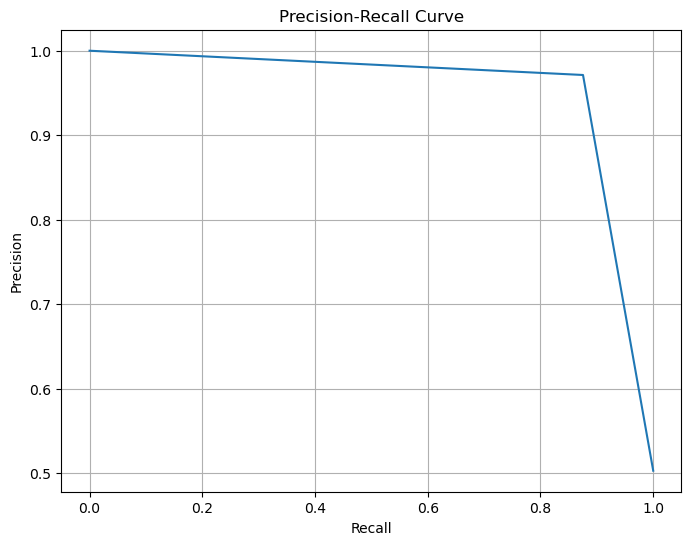

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val_mat, y_pred)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.925


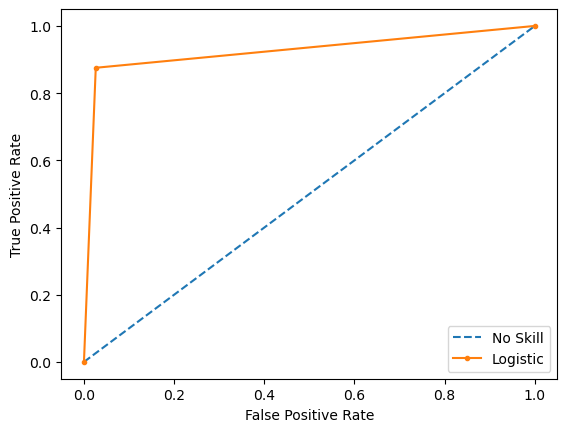

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val_mat))]

# predict probabilities
lr_probs = y_pred
# keep probabilities for the positive outcome only

# calculate scores
ns_auc = roc_auc_score(y_val_mat, ns_probs)
lr_auc = roc_auc_score(y_val_mat, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val_mat, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val_mat, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### simple nn
The neural network model presented here offers a fundamental architecture for binary image classification tasks. It comprises several key components meticulously designed to process and learn from image data efficiently.

At the forefront lies the input layer, where images are flattened into a vector representation. With dimensions set to 64x64x3, reflecting the image's height, width, and RGB color channels, this layer serves as the entry point for the model's computations.

Moving deeper, the model incorporates dense layers, each contributing to feature extraction and representation learning. The initial dense layer, with 128 neurons and ReLU activation, acts as a feature extractor, identifying essential patterns within the flattened input. Subsequently, a second dense layer with 64 neurons refines these learned features, potentially capturing more intricate details present in the images.

To prevent overfitting and enhance generalization, a dropout layer is strategically placed after the first dense layer. With a dropout rate of 0.5, this layer randomly drops 50% of the neurons during each training iteration, promoting robustness and reducing the likelihood of the model memorizing noise in the training data.

Finally, the output layer employs a single neuron with sigmoid activation, offering probabilities of the input images belonging to the positive class in a binary classification scenario. The sigmoid function ensures output values are bounded between 0 and 1, facilitating intuitive interpretation as class probabilities.

In terms of training, the model is compiled using the Adam optimizer and binary cross-entropy loss function, while accuracy serves as the primary evaluation metric. This setup optimizes the model's parameters iteratively, adjusting them to minimize the loss and improve classification accuracy.

Overall, this neural network architecture embodies a foundational framework for binary image classification, providing a balance between computational efficiency and predictive performance. Through careful tuning of hyperparameters and training on relevant datasets, this model can serve as a robust tool for a variety of real-world classification tasks.

In [44]:
# Define the neural network model
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Flatten the input images
    Dense(128, activation='relu'),     # Dense layer with 128 neurons and ReLU activation
    Dropout(0.5),                       # Dropout layer with dropout rate of 0.5
    Dense(64, activation='relu'),      # Dense layer with 64 neurons and ReLU activation
    Dense(1, activation='sigmoid')      # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',     # Adam optimizer
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])        # Monitor accuracy during training

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               1572992   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,581,313
Trainable params: 1,581,313
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_mat, y_test_mat)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/50
356/356 [==============================] - 11s 26ms/step - loss: 0.2779 - accuracy: 0.8815 - val_loss: 0.2724 - val_accuracy: 0.8906
Epoch 2/50
356/356 [==============================] - 8s 22ms/step - loss: 0.2709 - accuracy: 0.8845 - val_loss: 0.2351 - val_accuracy: 0.9233
Epoch 3/50
356/356 [==============================] - 8s 23ms/step - loss: 0.2875 - accuracy: 0.8765 - val_loss: 0.2575 - val_accuracy: 0.9247
Epoch 4/50
356/356 [==============================] - 7s 20ms/step - loss: 0.2645 - accuracy: 0.8887 - val_loss: 0.2150 - val_accuracy: 0.9222
Epoch 5/50
356/356 [==============================] - 7s 20ms/step - loss: 0.2762 - accuracy: 0.8932 - val_loss: 0.2070 - val_accuracy: 0.9222
Epoch 6/50
356/356 [==============================] - 7s 20ms/step - loss: 0.2616 - accuracy: 0.8952 - val_loss: 0.2406 - val_accuracy: 0.9254
Epoch 7/50
356/356 [==============================] - 7s 18ms/step - loss: 0.2511 - accuracy: 0.9009 - val_loss: 0.2053 - val_accuracy: 0.923

In [33]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so we use sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 128)       

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=10, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_mat, y_test_mat)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000269EA5AF9C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000269EA5AF9C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. O

In [98]:
training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


In [99]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [100]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["acc"])

In [101]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [102]:
history = model.fit(training_set, epochs=10,validation_data = validation_set, callbacks=[early_stopping],batch_size=32)

Epoch 1/10
356/356 [==============================] - 60s 166ms/step - loss: 0.2516 - acc: 0.8906 - val_loss: 0.1172 - val_acc: 0.9539
Epoch 2/10
356/356 [==============================] - 59s 165ms/step - loss: 0.1043 - acc: 0.9629 - val_loss: 0.0999 - val_acc: 0.9676
Epoch 3/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0665 - acc: 0.9770 - val_loss: 0.0637 - val_acc: 0.9799
Epoch 4/10
356/356 [==============================] - 60s 167ms/step - loss: 0.0613 - acc: 0.9792 - val_loss: 0.0368 - val_acc: 0.9880
Epoch 5/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0532 - acc: 0.9842 - val_loss: 0.0277 - val_acc: 0.9901
Epoch 6/10
356/356 [==============================] - 60s 169ms/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.0350 - val_acc: 0.9884
Epoch 6: early stopping


In [103]:
test_score = model.evaluate(test_set)

111/111 [==============================] - 6s 57ms/step - loss: 0.0266 - acc: 0.9896


In [104]:
print(f'Test Score:{test_score[1]}')
print(f'Test Loss:{test_score[0]}')

Test Score:0.9895833134651184
Test Loss:0.026605362072587013
